In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
data_path='/kaggle/input/chest-xray-pneumonia/chest_xray/' 
train_path=data_path+'train/' 
valid_path=data_path+'val/' 
test_path=data_path+'test/' 

In [3]:
from glob import glob 

print(f'훈련 데이터 개수:{len(glob(train_path+"*/*"))}')
print(f'검증 데이터 개수:{len(glob(valid_path+"*/*"))}') 
print(f'테스트 데이터 개수: {len(glob(test_path+"*/*"))}')  
#검증 데이터가 별로 없음--> 검증 데이터 성능 점수를 지나치게 신뢰할 필요x

훈련 데이터 개수:5216
검증 데이터 개수:16
테스트 데이터 개수: 624


In [4]:
glob(train_path +"*")

['/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL']

In [5]:
len(glob(train_path+"*/*") )

5216

In [6]:
#타깃값(정상 이미지, 폐렴 이미지)별 개수 구하기 

all_normal_imgs=[]
all_pneumonia_imgs=[] 

for cat in ['train/','val/','test/']:
    data_cat_path=data_path +cat 
    #정상,폐렴 이미지 경로 
    normal_imgs=glob(data_cat_path + 'NORMAL/*')
    pneumonia_imgs=glob(data_cat_path +'PNEUMONIA/*') 
    #정상,폐렴 이미지 경로를 리스트에 추가 
    all_normal_imgs.extend(normal_imgs) 
    all_pneumonia_imgs.extend(pneumonia_imgs)
    
print(f'정상 흉부 이미지 개수 : {len(all_normal_imgs)}') 
print(f'폐렴 흉부 이미지 개수: {len(all_pneumonia_imgs)}') 

정상 흉부 이미지 개수 : 1583
폐렴 흉부 이미지 개수: 4273


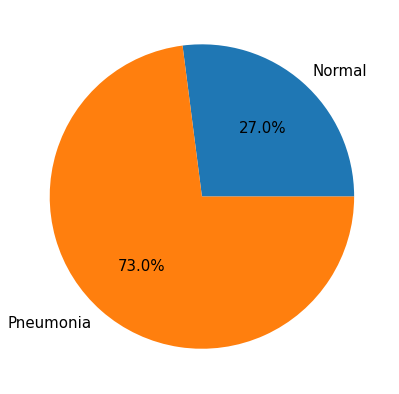

In [7]:
#데이서 시각화 
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline 

mpl.rc('font', size=15)
plt.figure(figsize=(7,7)) 

label=['Normal','Pneumonia'] #타깃값 레이블 
#타깃값 분포 파이 그래프 
plt.pie([len(all_normal_imgs), len(all_pneumonia_imgs)], labels=label, autopct='%.1f%%'); 

In [8]:
#이미지 출력 
import matplotlib.gridspec as gridspec
import cv2

def show_image(img_paths, rows=2, cols=3):
    assert len(img_paths) <= rows*cols
    
    mpl.rc('font', size=8)
    plt.figure(figsize=(15,8)) 
    grid=gridspec.GridSpec(rows, cols) 
    
    #이미지 출력 
    for idx, img_path in enumerate(img_paths):
        image=cv2.imread(img_path) #이미지 파일 읽기 
        ax=plt.subplot(grid[idx])
        ax.imshow(image) #이미지 출력

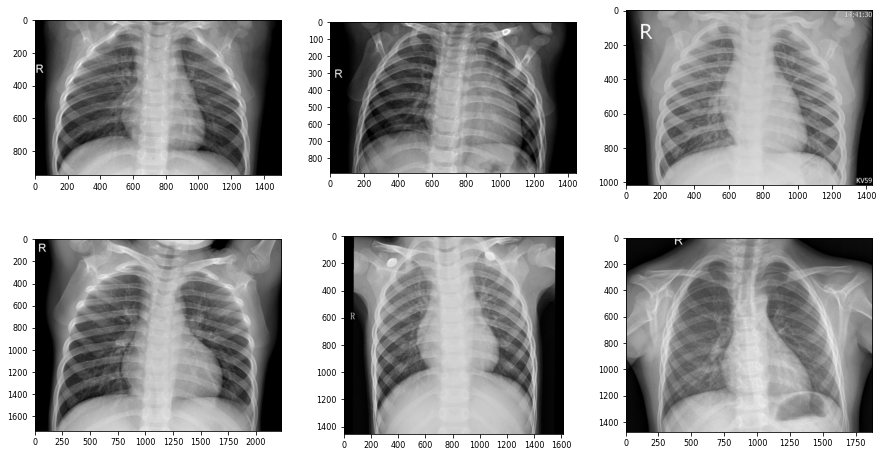

In [9]:
#정상 엑스선 이미지 경로(마지막 6장) 
num_of_imgs=6
normal_img_paths=all_normal_imgs[-num_of_imgs:]

#이미지 출력 
show_image(normal_img_paths) 

#이미지 크기가 제각각이라는 것을 알 수 있음 

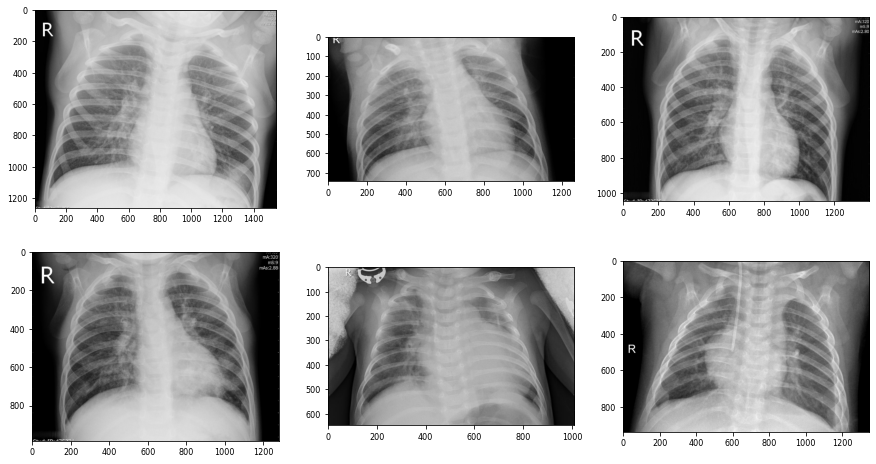

In [10]:
#폐렴 엑스선 이미지 경로(마지막 6장)
pneumonia_img_paths=all_pneumonia_imgs[-num_of_imgs:] 

#이미지 출력 
show_image(pneumonia_img_paths)

In [11]:
import torch 
import random
import numpy as np
import os 

#시드값 고정 
seed=50 
os.environ['PYTHONHASHSEED']=str(seed) 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
torch.backends.cudnn.enabled=False

In [12]:
#장비 설정 
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
device

device(type='cpu')

In [14]:
#데이터 증강을 위한 이미지 변환기 정의 
from torchvision import transforms

#훈련 데이터용 변환기
transform_train=transforms.Compose([transforms.Resize((250,250)),
                                   transforms.CenterCrop(180),
                                   transforms.RandomHorizontalFlip(0.5),
                                   transforms.RandomRotation(20),
                                   transforms.RandomVerticalFlip(0.2),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))]) 
transform_test=transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.CenterCrop(180),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                        (0.229, 0.224, 0.225))
    
])

In [15]:
#훈련, 검증 데이터셋 만들기 
from torchvision.datasets import ImageFolder 

#훈련 데이터셋 
datasets_train=ImageFolder(root=train_path, transform=transform_train) 
#검증 데이터셋
datasets_valid=ImageFolder(root=valid_path, transform=transform_test)

In [16]:
#멀티프로세싱 사용 
def seed_worker(worker_id):
    worker_seed=torch.initial_seed() %2**32 
    np.random.seed(worker_seed) 
    random.seed(worker_seed) 
    
#제너레이터 시드값 고정 
g=torch.Generator()
g.manual_seed(0) 

In [17]:
from torch.utils.data import DataLoader

batch_size=8

loader_train=DataLoader(dataset=datasets_train, batch_size=batch_size,shuffle=True,worker_init_fn=seed_worker, generator=g, num_workers=2) 

loader_valid=DataLoader(dataset=datasets_valid, batch_size=batch_size,shuffle=False,worker_init_fn=seed_worker, generator=g, num_workers=2)

In [18]:
#모델 생성

!pip install efficientnet-pytorch==0.7.1 

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=0cd7469507ba6431fd8c68a36a01a065320af695bdf3211df13532569dbaa781
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [19]:
from efficientnet_pytorch import EfficientNet
#모델 생성 
model=EfficientNet.from_pretrained('efficientnet-b0', num_classes=2) #이진 문제를 다루고 있으므로 num_classes=2
#장비 할당
model=model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [20]:
print('모델 파라미터 개수: ', sum(param.numel() for param in model.parameters())) 

모델 파라미터 개수:  4010110


In [21]:
#모델 훈련 및 성능 검증 
import torch.nn as nn 
criterion=nn.CrossEntropyLoss() 

In [22]:
optimizer=torch.optim.Adam(model.parameters(), lr=0.01)

In [23]:
#훈련 
def train(model,loader_train, loader_valid, criterion, optimizer, scheduler=None, epochs=10, save_file='model_stat_dict.pth'):
    valid_loss_min=np,inf #최소 손실값 초기화 
    
    #총 에폭만큼 반복 
    for epoch in range(epochs):
        print